## Linear regression of parameters and mobiscore
* Using PySpark ML Linear regression

In [500]:
import os
# needed to get workers and driver to work with same python version
os.environ['PYSPARK_PYTHON'] = "/usr/bin/python3"  #/home/anaconda3/bin/python
os.environ['PYSPARK_DRIVER_PYTHON'] = "/usr/bin/python3"

In [501]:
import pyspark
from pyspark.sql import SparkSession

from pyspark.sql.functions import udf, lower, col
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, FloatType, StringType, StructType, StructField
from pyspark.sql.functions import udf, pandas_udf, PandasUDFType

import matplotlib.pylab as plt
import pandas as pd
import time
from collections import Counter

from definitions import OUTPUT_PATH, RESOURCE_PATH

In [ ]:
spark = SparkSession \
    .builder \
    .getOrCreate()

## Explore master_ddf

In [503]:
master_ddf_raw = spark.read.csv(os.path.join(OUTPUT_PATH, 'statsec_master.csv'),header=True,sep=",")
print(master_ddf_raw.take(1))
master_ddf_raw.printSchema()
master_ddf_raw = master_ddf_raw.withColumn('KBO_km2', col("KBO_1K") * col("population") / col("opp(hm2)") )

[Row(statsec='11001A00-', Num Of Addr='10', avg(mobiscore)='8.13000020980835', avg(public_transport)='4.0', avg(education)='5.0', avg(commercial)='5.0', avg(leisure)='4.0', avg(healthcare)='5.0', municipality='Aartselaar', opp(hm2)='53.1579943729947', population='2509', pop_density(perkm2)='4719.892', MS_NBR_NON_ZERO_INC='1481', MS_AVG_TOT_NET_TAXABLE_INC='37808.233707', MS_MEDIAN_NET_TAXABLE_INC='27189.55', total_houses='1087', avg_rooms='5.080957', cars_1K='3860.0', covid_1K='8.8854685', KBO_1K='250.29892')]
root
 |-- statsec: string (nullable = true)
 |-- Num Of Addr: string (nullable = true)
 |-- avg(mobiscore): string (nullable = true)
 |-- avg(public_transport): string (nullable = true)
 |-- avg(education): string (nullable = true)
 |-- avg(commercial): string (nullable = true)
 |-- avg(leisure): string (nullable = true)
 |-- avg(healthcare): string (nullable = true)
 |-- municipality: string (nullable = true)
 |-- opp(hm2): string (nullable = true)
 |-- population: string (nulla

#### Cast columns to appropriate type

In [504]:
# Cast to floats
master_ddf = master_ddf_raw .withColumn("Num of Addr", master_ddf_raw["Num of Addr"].cast(IntegerType())) \
                            .withColumn("avg(mobiscore)", master_ddf_raw["avg(mobiscore)"].cast(FloatType())) \
                            .withColumn("avg(public_transport)", master_ddf_raw["avg(public_transport)"].cast(FloatType())) \
                            .withColumn("avg(education)", master_ddf_raw["avg(education)"].cast(FloatType())) \
                            .withColumn("avg(commercial)", master_ddf_raw["avg(commercial)"].cast(FloatType())) \
                            .withColumn("avg(leisure)", master_ddf_raw["avg(leisure)"].cast(FloatType())) \
                            .withColumn("avg(healthcare)", master_ddf_raw["avg(healthcare)"].cast(FloatType())) \
                            .withColumn("pop_density(perkm2)", master_ddf_raw["pop_density(perkm2)"].cast(FloatType())) \
                            .withColumn("MS_AVG_TOT_NET_TAXABLE_INC", master_ddf_raw["MS_AVG_TOT_NET_TAXABLE_INC"].cast(FloatType())) \
                            .withColumn("total_houses", master_ddf_raw["total_houses"].cast(FloatType())) \
                            .withColumn("avg_rooms", master_ddf_raw["avg_rooms"].cast(FloatType())) \
                            .withColumn("cars_1K", master_ddf_raw["cars_1K"].cast(FloatType())) \
                            .withColumn("covid_1K", master_ddf_raw["covid_1K"].cast(FloatType())) \
                            .withColumn("KBO_1K", master_ddf_raw["KBO_1K"].cast(FloatType())) \
                            .withColumn("KBO_km2", master_ddf_raw["KBO_km2"].cast(FloatType())) 
master_ddf.printSchema()



root
 |-- statsec: string (nullable = true)
 |-- Num of Addr: integer (nullable = true)
 |-- avg(mobiscore): float (nullable = true)
 |-- avg(public_transport): float (nullable = true)
 |-- avg(education): float (nullable = true)
 |-- avg(commercial): float (nullable = true)
 |-- avg(leisure): float (nullable = true)
 |-- avg(healthcare): float (nullable = true)
 |-- municipality: string (nullable = true)
 |-- opp(hm2): string (nullable = true)
 |-- population: string (nullable = true)
 |-- pop_density(perkm2): float (nullable = true)
 |-- MS_NBR_NON_ZERO_INC: string (nullable = true)
 |-- MS_AVG_TOT_NET_TAXABLE_INC: float (nullable = true)
 |-- MS_MEDIAN_NET_TAXABLE_INC: string (nullable = true)
 |-- total_houses: float (nullable = true)
 |-- avg_rooms: float (nullable = true)
 |-- cars_1K: float (nullable = true)
 |-- covid_1K: float (nullable = true)
 |-- KBO_1K: float (nullable = true)
 |-- KBO_km2: float (nullable = true)



## Import PySpark MLlib linear regression

In [505]:
import six
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
import matplotlib.pyplot as plt
import math

### Looking at individual parameters

In [506]:
master_df = master_ddf.toPandas()

#### POP_DENSITY

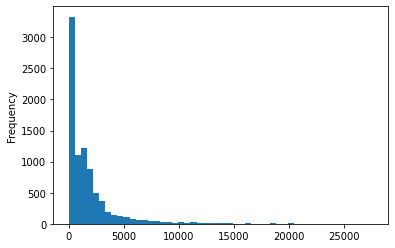

In [507]:
master_df['pop_density(perkm2)'].plot.hist(bins=50)

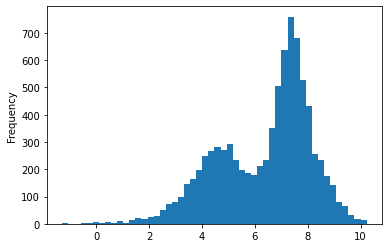

In [508]:
#master_df['population'] = master_df['population'].astype('float')

def take_log(row):
    if row['pop_density(perkm2)'] > 0:
        row['log(pop_density(perkm2))'] = math.log(row['pop_density(perkm2)'])
    else:
        row['log(pop_density(perkm2))'] = 0
    return row

master_df = master_df.apply(take_log, axis=1)
master_df['log(pop_density(perkm2))'].plot.hist(bins=50)

#### MS_AVG_TOT_NET_TAXABLE_INC

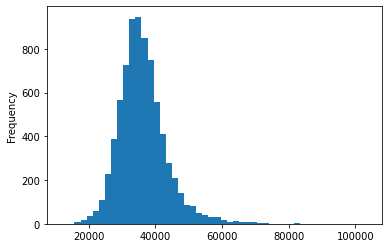

In [509]:
master_df['MS_AVG_TOT_NET_TAXABLE_INC'].plot.hist(bins=50)

### Visually explore correlations

In [510]:
from pandas.plotting import scatter_matrix

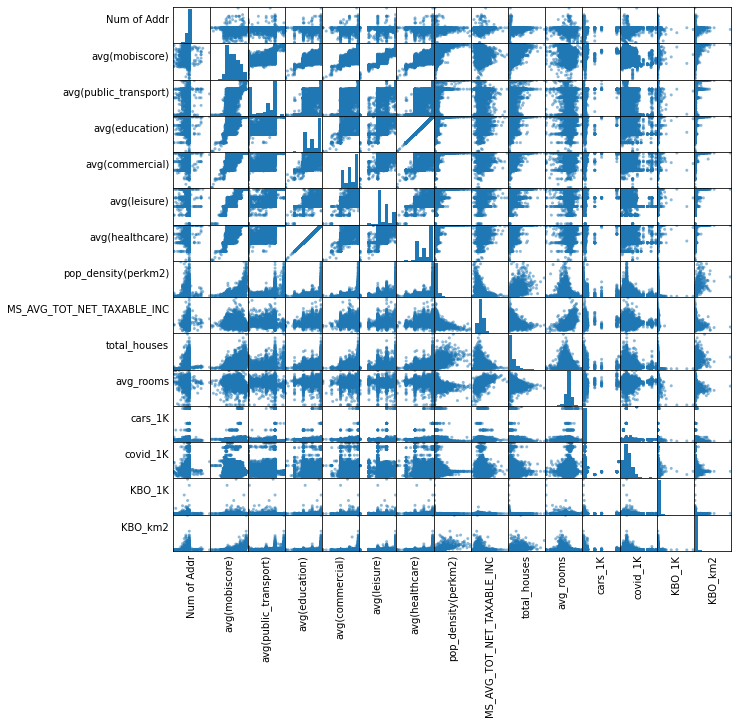

In [511]:
numeric_features = [t[0] for t in master_ddf.dtypes if t[1] == 'int' or t[1] == 'float']
sampled_data = master_ddf.select(numeric_features).sample(False, 0.8).toPandas()
axs = scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

### Numerically exploring correlations

In [512]:
for i in master_ddf.columns:
    if not(isinstance(master_ddf.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to mobiscore for ", i, master_ddf.stat.corr('avg(mobiscore)',i))

Correlation to mobiscore for  Num of Addr -0.024747565470904877
Correlation to mobiscore for  avg(mobiscore) 1.0
Correlation to mobiscore for  avg(public_transport) 0.756513644386873
Correlation to mobiscore for  avg(education) 0.7877648043264502
Correlation to mobiscore for  avg(commercial) 0.8173767807736618
Correlation to mobiscore for  avg(leisure) 0.8947745497158193
Correlation to mobiscore for  avg(healthcare) 0.7877648043264502
Correlation to mobiscore for  pop_density(perkm2) 0.5520032573934208
Correlation to mobiscore for  MS_AVG_TOT_NET_TAXABLE_INC 0.03543845696149448
Correlation to mobiscore for  total_houses 0.43694366869941326
Correlation to mobiscore for  avg_rooms -0.3363669903328374
Correlation to mobiscore for  cars_1K 0.05854769353557066
Correlation to mobiscore for  covid_1K -0.08687395535002052
Correlation to mobiscore for  KBO_1K 0.01829175509098231
Correlation to mobiscore for  KBO_km2 0.4309158788900646


#### Refactor variables

In [528]:
udf_log = udf(lambda x: math.log(x) if x >0 else 0, FloatType())
udf_car = udf(lambda x: (x if x < 1000.0 else 546.0) if x is not None else 546.0, FloatType())

In [529]:
master_ddf_log = master_ddf.withColumn('pop_density_log', udf_log('pop_density(perkm2)'))
master_ddf_log = master_ddf_log.withColumn('cars_1K_fix', udf_car('cars_1K'))
master_ddf_log.printSchema()

root
 |-- statsec: string (nullable = true)
 |-- Num of Addr: integer (nullable = true)
 |-- avg(mobiscore): float (nullable = true)
 |-- avg(public_transport): float (nullable = true)
 |-- avg(education): float (nullable = true)
 |-- avg(commercial): float (nullable = true)
 |-- avg(leisure): float (nullable = true)
 |-- avg(healthcare): float (nullable = true)
 |-- municipality: string (nullable = true)
 |-- opp(hm2): string (nullable = true)
 |-- population: string (nullable = true)
 |-- pop_density(perkm2): float (nullable = true)
 |-- MS_NBR_NON_ZERO_INC: string (nullable = true)
 |-- MS_AVG_TOT_NET_TAXABLE_INC: float (nullable = true)
 |-- MS_MEDIAN_NET_TAXABLE_INC: string (nullable = true)
 |-- total_houses: float (nullable = true)
 |-- avg_rooms: float (nullable = true)
 |-- cars_1K: float (nullable = true)
 |-- covid_1K: float (nullable = true)
 |-- KBO_1K: float (nullable = true)
 |-- KBO_km2: float (nullable = true)
 |-- pop_density_log: float (nullable = true)
 |-- cars_1K_

In [530]:
splits = v_master_ddf.randomSplit([1.0])
train_df = splits[0]
#test_df = splits[1]
all_data = splits[0]

In [531]:
def getExpectedValuesSingle(intercept, coeff, ran):
    return [intercept+coeff*i for i in ran]


######  Perform individual regressions

avg(mobiscore) <- pop_density_log
Coefficients: [0.4006206112020438]
Intercept: 3.9706001093425543
pVals: [0.0, 0.0]
0.2243561841874656


avg(mobiscore) <- MS_AVG_TOT_NET_TAXABLE_INC
Coefficients: [-1.2509912246461075e-05]
Intercept: 7.022888479385104
pVals: [6.297096177831918e-08, 0.0]
0.0038370739648135865


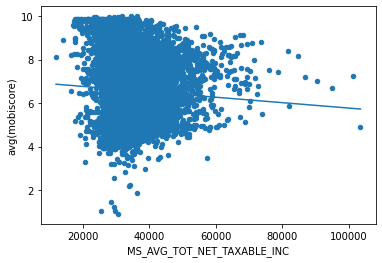

avg(mobiscore) <- total_houses
Coefficients: [0.0020730721373437917]
Intercept: 5.919400455650721
pVals: [0.0, 0.0]
0.19091976961650448


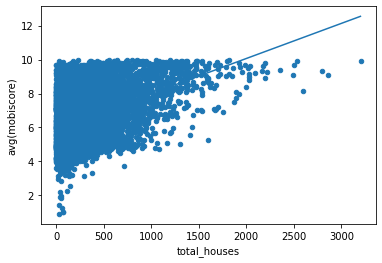

avg(mobiscore) <- avg_rooms
Coefficients: [-0.6580581203087024]
Intercept: 10.290409801036898
pVals: [0.0, 0.0]
0.11314275218556791


avg(mobiscore) <- cars_1K_fix
Coefficients: [-0.0063385676743418695]
Intercept: 9.787040922570265
pVals: [0.0, 0.0]
0.059652856117757835


avg(mobiscore) <- covid_1K
Coefficients: [-0.05589743752962258]
Intercept: 6.801468066101606
pVals: [2.220446049250313e-16, 0.0]
0.007961198987565532


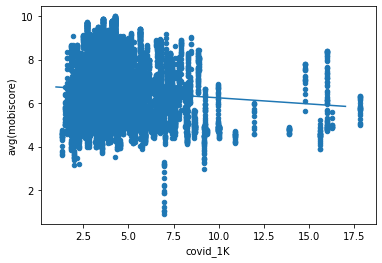

avg(mobiscore) <- KBO_km2
Coefficients: [7.680298769985947e-05]
Intercept: 6.245317305774009
pVals: [0.0, 0.0]
0.18576628602290046


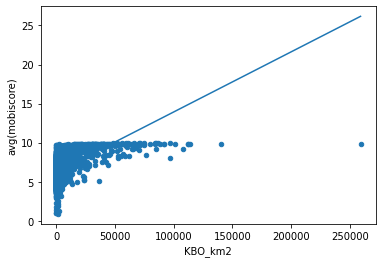

   intercept                   predictor  coefficient  pValue    min     max  \
0   3.970600             pop_density_log     0.400621     0.0     -2      11   
1   7.022888  MS_AVG_TOT_NET_TAXABLE_INC    -0.000013     0.0  12043  103443   
2   5.919400                total_houses     0.002073     0.0      1    3201   
3  10.290410                   avg_rooms    -0.658058     0.0      0       9   
4   9.787041                 cars_1K_fix    -0.006339     0.0    387     832   
5   6.801468                    covid_1K    -0.055897     0.0      1      18   
6   6.245317                     KBO_km2     0.000077     0.0      2  259255   

         R2  
0  0.224356  
1  0.003837  
2  0.190920  
3  0.113143  
4  0.059653  
5  0.007961  
6  0.185766  


In [540]:
import math
cols = [#'avg(mobiscore)', 
        'pop_density_log', 
        'MS_AVG_TOT_NET_TAXABLE_INC',
        'total_houses',
        'avg_rooms',
        'cars_1K_fix',
        'covid_1K',
        'KBO_km2'
       ]
master_pd_df = master_ddf_log.toPandas()
master_pd_df[['avg(mobiscore)', 
                'pop_density_log', 
                'MS_AVG_TOT_NET_TAXABLE_INC',
                'total_houses',
                'avg_rooms',
                'cars_1K_fix',
                'covid_1K',
                'KBO_km2'
       ]]
individual_regr_df = pd.DataFrame(columns=["intercept", "predictor","coefficient", "pValue", "min", "max"])

for label_col in cols:
    
    vectorAssembler = VectorAssembler(inputCols = [label_col
                                              ], outputCol = 'features', 
                                              handleInvalid = "skip")
    v_master_ddf = vectorAssembler.transform(master_ddf_log)
    v_master_ddf = v_master_ddf.select(['features', 'avg(mobiscore)'])
    #v_master_ddf.show(5)
    
    
    print('avg(mobiscore)','<-',label_col)
    lr = LinearRegression(featuresCol = 'features' , labelCol='avg(mobiscore)')  #, maxIter=10, regParam=0.3, elasticNetParam=0.8
    lr_model = lr.fit(v_master_ddf)
    print("Coefficients: " + str(lr_model.coefficients))
    print("Intercept: " + str(lr_model.intercept))
    print("pVals: " + str(lr_model.summary.pValues))
    print(lr_model.summary.r2)
    #print(master_ddf_log.toPandas().head())
    ax = master_pd_df[[label_col,'avg(mobiscore)' ]].plot.scatter(y='avg(mobiscore)', x=label_col)
    rn = [i for i in range(math.floor(master_pd_df[label_col].min()), math.ceil(master_pd_df[label_col].max()))]
    exp_vals = getExpectedValues(lr_model.intercept, lr_model.coefficients[0], rn)
    plt.plot(rn, exp_vals)
    plt.show()
    
    individual_regr_df = individual_regr_df.append({"intercept": lr_model.intercept,"predictor":label_col, "coefficient":lr_model.coefficients[0], 
                                                    "pValue": lr_model.summary.pValues[1],
                                                   "min":math.floor(master_pd_df[label_col].min()), 
                                                    "max":math.ceil(master_pd_df[label_col].max()),
                                                    "R2": lr_model.summary.r2
                                                   },ignore_index=True)
print(individual_regr_df.head(20))
individual_regr_df.to_csv("output/individual_regressions_params.csv", index=False)

In [533]:
master_pd_df[['avg(mobiscore)', 
                'pop_density_log', 
                'MS_AVG_TOT_NET_TAXABLE_INC',
                'total_houses',
                'avg_rooms',
                'cars_1K_fix',
                'covid_1K',
                'KBO_km2',
              'statsec'
       ]].to_csv("output/individual_regression_input.csv", index=False)

### What do we learn from individual regressions? 
- All parameters are significant. (large sample)
- High impact params:
    - population density (+)
    - Total houses (+)
    - AVG rooms (-)

In [534]:
vectorAssembler = VectorAssembler(inputCols = cols,
                                  outputCol = 'features', 
                                  handleInvalid = "skip")

v_master_ddf = vectorAssembler.transform(master_ddf_log)
v_master_ddf = v_master_ddf.select(['features', 'avg(mobiscore)'])
#v_master_ddf.show(5)


print('avg(mobiscore)','<-',cols)
lr = LinearRegression(featuresCol = 'features' , labelCol='avg(mobiscore)')  #, maxIter=10, regParam=0.3, elasticNetParam=0.8
lr_model = lr.fit(v_master_ddf)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))
print("pVals: " + str(lr_model.summary.pValues))

for i in zip(["Intercept"] + cols, 
             [round(i,5) for i in [lr_model.intercept]+list(lr_model.coefficients)],
             [round(i,5) for i in lr_model.summary.pValues],[0]+ [str(master_pd_df[col].max()) for col in cols],
             [0]+ [master_pd_df[col].mean() for col in cols],
            [0]+ [str(master_pd_df[col].min()) for col in cols]):
    print(i, round(i[1]/i[-2],7) if i[0] != "Intercept" else 0)

print(lr_model.summary.r2)

avg(mobiscore) <- ['pop_density_log', 'MS_AVG_TOT_NET_TAXABLE_INC', 'total_houses', 'avg_rooms', 'cars_1K_fix', 'covid_1K', 'KBO_km2']
Coefficients: [0.31026244463676994,3.909670365377733e-05,0.0006397824836406852,-0.5203252507246307,-0.0026665226969179744,-0.006838431353381764,2.630897535281302e-05]
Intercept: 7.156932304198584
pVals: [0.0, 0.0, 0.0, 0.0, 0.0, 0.22530099037889872, 0.0, 0.0]
('Intercept', 7.15693, 0.0, 0, 0, 0) 0
('pop_density_log', 0.31026, 0.0, '10.228332', 6.3880095, '-1.283345') 0.0485691
('MS_AVG_TOT_NET_TAXABLE_INC', 4e-05, 0.0, '103442.305', 36220.605, '12043.606') 0.0
('total_houses', 0.00064, 0.0, '3201.0', 294.41028, '1.0') 2.2e-06
('avg_rooms', -0.52033, 0.0, '9.0', 5.7148075, '0.0') -0.0910494
('cars_1K_fix', -0.00267, 0.2253, '832.0', 513.88684, '387.0') -5.2e-06
('covid_1K', -0.00684, 0.0, '17.827637', 4.8330603, '1.3268465') -0.0014153
('KBO_km2', 3e-05, 0.0, '259254.1', 3703.6455, '2.6961381') 0.0
0.41246216983001693


## Best predictors: pop_density, avg_rooms, total houses, cars

In [535]:
regre_model_cols = [#'avg(mobiscore)', 
        'pop_density_log', 
        'total_houses',
        'avg_rooms',
        'cars_1K_fix',
       ]
vectorAssembler = VectorAssembler(inputCols = regre_model_cols,
                                  outputCol = 'features', 
                                  handleInvalid = "skip")

v_master_ddf = vectorAssembler.transform(master_ddf_log)
v_master_ddf = v_master_ddf.select(['features', 'avg(mobiscore)'])
#v_master_ddf.show(5)


print('avg(mobiscore)','<-',regre_model_cols)
lr = LinearRegression(featuresCol = 'features' , labelCol='avg(mobiscore)')  #, maxIter=10, regParam=0.3, elasticNetParam=0.8
lr_model = lr.fit(v_master_ddf)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))
print("pVals: " + str(lr_model.summary.pValues))

regression_params_df = pd.DataFrame(columns=["predictor","coefficient", "pValue"])

for i in zip(["intercept"] + regre_model_cols, 
             [round(i,5) for i in [lr_model.intercept]+list(lr_model.coefficients)],
             [round(i,10) for i in lr_model.summary.pValues],[0]+ [str(master_pd_df[col].max()) for col in regre_model_cols],
             [0]+ [master_pd_df[col].mean() for col in regre_model_cols],
            [0]+ [str(master_pd_df[col].min()) for col in regre_model_cols]):
    
    regression_params_df = regression_params_df.append({"predictor":i[0], "coefficient":i[1], "pValue": i[2]},ignore_index=True)
    print(i, round(i[1]/i[-2],7) if i[0] != "intercept" else 0)
print(lr_model.summary.r2)


print(regression_params_df.head(20))

avg(mobiscore) <- ['pop_density_log', 'total_houses', 'avg_rooms', 'cars_1K_fix']
Coefficients: [0.26108274758498407,0.0007864739611503895,-0.3765418279035925,-0.0037618603032157547]
Intercept: 8.715368736590474
pVals: [0.0, 0.0, 0.0, 0.0, 0.0]
('intercept', 8.71537, 0.0, 0, 0, 0) 0
('pop_density_log', 0.26108, 0.0, '10.228332', 6.3880095, '-1.283345') 0.0408703
('total_houses', 0.00079, 0.0, '3201.0', 294.41028, '1.0') 2.7e-06
('avg_rooms', -0.37654, 0.0, '9.0', 5.7148075, '0.0') -0.0658885
('cars_1K_fix', -0.00376, 0.0, '832.0', 513.88684, '387.0') -7.3e-06
0.31902387761546225
         predictor  coefficient  pValue
0        intercept      8.71537     0.0
1  pop_density_log      0.26108     0.0
2     total_houses      0.00079     0.0
3        avg_rooms     -0.37654     0.0
4      cars_1K_fix     -0.00376     0.0


In [536]:
print(master_pd_df.columns)
predictions = master_pd_df[['avg(mobiscore)','pop_density_log', 'total_houses', 'avg_rooms', 'cars_1K_fix', 'statsec']].dropna(thresh=5)
coeffs = regression_params_df["coefficient"].to_list()
predictions["prediction"] = predictions.apply(lambda x: 
                                              coeffs[0]  
                                              + x.pop_density_log*coeffs[1] 
                                              + x.total_houses*coeffs[2] 
                                              + x.avg_rooms*coeffs[3] 
                                              + x.cars_1K_fix*coeffs[4] 
                                              , axis=1)
predictions["error"] = predictions.apply(lambda x: x['avg(mobiscore)'] - x.prediction, axis=1)
stdev = (sum([i**2 for i in predictions["error"].to_list()])/len(predictions["error"]))**0.5
print(stdev)
print(predictions.head(100))
regression_params_df.to_csv("output/regression_params_accepted_model.csv", index=False)
predictions.to_csv("output/regression_accepted_model_data.csv", index=False)

Index(['statsec', 'Num of Addr', 'avg(mobiscore)', 'avg(public_transport)',
       'avg(education)', 'avg(commercial)', 'avg(leisure)', 'avg(healthcare)',
       'municipality', 'opp(hm2)', 'population', 'pop_density(perkm2)',
       'MS_NBR_NON_ZERO_INC', 'MS_AVG_TOT_NET_TAXABLE_INC',
       'MS_MEDIAN_NET_TAXABLE_INC', 'total_houses', 'avg_rooms', 'cars_1K',
       'covid_1K', 'KBO_1K', 'KBO_km2', 'pop_density_log', 'cars_1K_fix'],
      dtype='object')
nan
    avg(mobiscore)  pop_density_log  total_houses  avg_rooms  cars_1K_fix  \
0         8.130000         8.459541        1087.0   5.080957        546.0   
1         8.100000         8.294950        1167.0   5.539846        546.0   
2         7.910000         7.839440         267.0   5.898876        546.0   
3         7.800000         6.919238         178.0   5.455056        546.0   
4         7.977778         7.222001         137.0   6.635036        546.0   
5         8.090000         8.757788         903.0   5.244740        546.0 

# Predict Covids based on mobiscore and population density

root
 |-- features: vector (nullable = true)
 |-- covid_1k: float (nullable = true)

+-------------------+---------+
|           features| covid_1k|
+-------------------+---------+
|[8.130000114440918]|8.8854685|
|[8.100000381469727]|8.8854685|
|[7.910000324249268]|8.8854685|
|[7.800000190734863]|8.8854685|
| [7.97777795791626]|8.8854685|
+-------------------+---------+
only showing top 5 rows

covid_1k <- ['avg(mobiscore)']
Coefficients: [-0.14242511534350707]
Intercept: 5.763283649563685
pVals: [2.220446049250313e-16, 0.0]
('intercept', 5.76328, 0.0, 0, 0, 0) 0
('avg(mobiscore)', -0.14243, 0.0, '10.0', 6.529734, '0.89') -0.0218125
                                   avg(mobiscore)   covid_1K
municipality                NIS                             
Aalst (Aalst)               41002        6.988782   5.841865
Aarschot                    24001        7.538694   4.980906
Aartselaar                  11001        7.897357   8.885468
Affligem                    23105        6.172615   3.

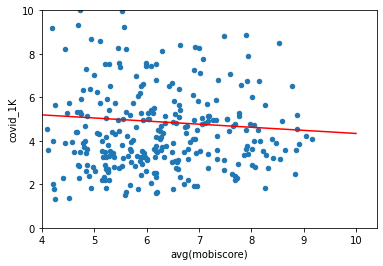

0.007961198987564533
        predictor  coefficient  pValue
0       intercept      5.76328     0.0
1  avg(mobiscore)     -0.14243     0.0


In [537]:
regre_model_cols = [#'avg(mobiscore)', 
        'avg(mobiscore)'
       ]
vectorAssembler = VectorAssembler(inputCols = regre_model_cols,
                                  outputCol = 'features', 
                                  handleInvalid = "skip")

v_master_ddf = vectorAssembler.transform(master_ddf_log)
v_master_ddf = v_master_ddf.select(['features', 'covid_1k']).dropna(thresh=2)
v_master_ddf.printSchema()
v_master_ddf.show(5)


print('covid_1k','<-',regre_model_cols)
lr = LinearRegression(featuresCol = 'features' , labelCol='covid_1k')  #, maxIter=10, regParam=0.3, elasticNetParam=0.8
lr_model = lr.fit(v_master_ddf)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))
print("pVals: " + str(lr_model.summary.pValues))

regression_params_df = pd.DataFrame(columns=["predictor","coefficient", "pValue"])

for i in zip(["intercept"] + regre_model_cols, 
             [round(i,5) for i in [lr_model.intercept]+list(lr_model.coefficients)],
             [round(i,10) for i in lr_model.summary.pValues],[0]+ [str(master_pd_df[col].max()) for col in regre_model_cols],
             [0]+ [master_pd_df[col].mean() for col in regre_model_cols],
            [0]+ [str(master_pd_df[col].min()) for col in regre_model_cols]):
    
    regression_params_df = regression_params_df.append({"predictor":i[0], "coefficient":i[1], "pValue": i[2]},ignore_index=True)
    print(i, round(i[1]/i[-2],7) if i[0] != "intercept" else 0)
master_pd_df["NIS"] = master_pd_df.apply(lambda x: x.statsec[:5], axis=1)
print(master_pd_df[['avg(mobiscore)', 'covid_1K',"NIS", "municipality"]] \
      .groupby(["municipality","NIS"]).mean())

ax = master_pd_df[['avg(mobiscore)', 'covid_1K', "NIS","municipality"]] \
            .groupby(["municipality", "NIS"]).mean().reset_index() \
            .plot.scatter(y='covid_1K', x='avg(mobiscore)')


rn = [max(i,4) for i in range(math.floor(master_pd_df['avg(mobiscore)'].min()), math.ceil(master_pd_df['avg(mobiscore)'].max()+1))]
exp_vals = getExpectedValues(lr_model.intercept, lr_model.coefficients[0], rn)
plt.plot(rn, exp_vals, color="red")
plt.xlim(4)
plt.ylim(0,10)
plt.show()
    
print(lr_model.summary.r2)


print(regression_params_df.head(20))

master_pd_df[['avg(mobiscore)', 'covid_1K',"NIS", "municipality"]] \
      .groupby(["municipality","NIS"]).mean().reset_index() \
      .to_csv("output/regression_mobi_covid_muni.csv", index=False)
regression_params_df.to_csv("output/regression_mobi_covid_muni_PARAMS.csv", index=False)


In [538]:
train_df.describe().show()

+-------+------------------+
|summary|    avg(mobiscore)|
+-------+------------------+
|  count|              8296|
|   mean| 6.508165114526004|
| stddev|1.4916137529976048|
|    min|              0.89|
|    max|              10.0|
+-------+------------------+



In [539]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","avg(mobiscore)","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="avg(mobiscore)",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

Py4JJavaError: An error occurred while calling o41207.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 2842.0 failed 1 times, most recent failure: Lost task 0.0 in stage 2842.0 (TID 2842, localhost, executor driver): org.apache.spark.SparkException: Failed to execute user defined function($anonfun$1: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => double)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:255)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:247)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:858)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:858)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.IllegalArgumentException: requirement failed: BLAS.dot(x: Vector, y:Vector) was given Vectors with non-matching sizes: x.size = 2, y.size = 1
	at scala.Predef$.require(Predef.scala:224)
	at org.apache.spark.ml.linalg.BLAS$.dot(BLAS.scala:104)
	at org.apache.spark.ml.regression.LinearRegressionModel.predict(LinearRegression.scala:708)
	at org.apache.spark.ml.regression.LinearRegressionModel.predict(LinearRegression.scala:645)
	at org.apache.spark.ml.PredictionModel$$anonfun$1.apply(Predictor.scala:215)
	at org.apache.spark.ml.PredictionModel$$anonfun$1.apply(Predictor.scala:214)
	... 21 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1891)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1879)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1878)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1878)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:927)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:927)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:927)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2112)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2061)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2050)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:738)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:365)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:38)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$collectFromPlan(Dataset.scala:3389)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2550)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2550)
	at org.apache.spark.sql.Dataset$$anonfun$52.apply(Dataset.scala:3370)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:80)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:127)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:75)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3369)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2550)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2764)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:254)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:291)
	at sun.reflect.GeneratedMethodAccessor577.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Failed to execute user defined function($anonfun$1: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => double)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:255)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:247)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:858)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:858)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: java.lang.IllegalArgumentException: requirement failed: BLAS.dot(x: Vector, y:Vector) was given Vectors with non-matching sizes: x.size = 2, y.size = 1
	at scala.Predef$.require(Predef.scala:224)
	at org.apache.spark.ml.linalg.BLAS$.dot(BLAS.scala:104)
	at org.apache.spark.ml.regression.LinearRegressionModel.predict(LinearRegression.scala:708)
	at org.apache.spark.ml.regression.LinearRegressionModel.predict(LinearRegression.scala:645)
	at org.apache.spark.ml.PredictionModel$$anonfun$1.apply(Predictor.scala:215)
	at org.apache.spark.ml.PredictionModel$$anonfun$1.apply(Predictor.scala:214)
	... 21 more


In [ ]:
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)